# Teste 1 - Python

        Tentando importar e utilizar os dados do Ministério da Saúde em https://covid.saude.org.br para avaliar a situação divulgada oficialmente pelo MS; 
        A url muda diariamente... como puxar o arquivo csv automaticamente?

## Gráficos dos Dados

        Mostrar infectados e mortes confirmados diariamente
        Mostrar infectados e mortes confirmados acumulados
        Mostrar dados separados por região e por estado

## Estimativas (Regressão)
        
        Estimar próximos números (até 7 dias?) utilizando 2, 3 ou 4 (todos?) dias anteriores e regressão não linear
        
## Modelo de Contágio

        Utilizar dados adquiridos para rodar um modelo epidemiológico que utiliza valores de reprodução base e evolução da COVID-19, causada pelo vírus SARS-COV-2
  

In [75]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

url_S = "https://gitlab.procc.fiocruz.br/mave/repo/raw/master/Dados/InfoGripe/serie_temporal_com_estimativas_recentes.csv"
url_C = "https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/bac510aed31a05ec1fa30b344f238790_Download_COVID19_20200423.csv"

In [80]:
df = pd.read_csv(url_C, sep = ";")
df_SRAG = pd.read_csv(url_S, sep = ";")

In [81]:
FMT = '%Y-%m-%d'

date = df['data']
regi = df['regiao']

df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-30", FMT)).days)

In [99]:
df1 = df.loc[:, ['data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]
dfs = df.loc[:, ['regiao', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos', 'estado']]
df_UF = df.loc[:, ['estado', 'data', 'casosAcumulados', 'casosNovos', 'obitosAcumulados', 'obitosNovos']]

df_SRAG = df_SRAG.loc[:, ['Unidade da Federação', 'Tipo', 'dado', 'Ano epidemiológico', 'Semana epidemiológica', 'População']]
df_SRAG.drop(df_SRAG[df_SRAG["Ano epidemiológico"] != 2020].index, inplace=True)

df_Brasil = df_SRAG.loc[:, ['Unidade da Federação', 'Tipo', 'População']]
df_Brasil = df_Brasil.drop_duplicates("Unidade da Federação")

df_Brasil.reset_index(inplace = True, drop = True)
df_Brasil

,Unidade da Federação,Tipo,População
0,Rondônia,Estado,1857992
1,Acre,Estado,866811
2,Amazonas,Estado,4240210
3,Roraima,Estado,546891
4,Pará,Estado,8628901
5,Amapá,Estado,842914
6,Tocantins,Estado,1599316
7,Maranhão,Estado,7121156
8,Piauí,Estado,3233891
9,Ceará,Estado,9178363


In [46]:
df1 = df1.groupby("data").sum()

# total of days since 2020-01-30 - x
x = list(df1.index)


In [47]:
def exponential_model (x, a, b, c) :
    return a * np.exp (b * (x - c))

#curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

def exp_param (R, X) :
    np.random.seed(19)
    a = np.exp(X[2] * (((np.log(R[2]))/X[2]) - ((np.log(R[1]) - np.log(R[0]))/(X[1] - X[0]))))
    b = (np.log(R[2])/X[2]) - (1/X[2])*(((np.log(R[0])/X[0]) - (np.log(R[1])/X[1]))/((X[0])**(-1) - (X[1])**(-1)))
    return [a, b]

In [49]:
# total cases
x = list(df1.index)
y = list(df1.iloc[:, 0])

exp_p = exp_param([y[-1], y[-2], y[-4]], [x[-1], x[-2], x[-4]])
exponential_fit = curve_fit(exponential_model, x, y, p0 = [exp_p[0], exp_p[1], 1], bounds = (0, df.index.size))
#exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], 
                                                          exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))
exponential_errors = [np.sqrt(exponential_fit[1][i][i]) for i in [0, 1, 2]]
exponential_errors

[1322313.639621959, 0.0016816198208645077, 389836.1138617162]

In [50]:
# new cases
y = list(df1.iloc[:, 1])

new_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_exponential_fit[0][0],
                                                              new_exponential_fit[0][1], 
                                                              new_exponential_fit[0][2]) - int(new_exponential_fit[0][2]), new_exponential_fit[0][1]))
new_exponential_errors = [np.sqrt(new_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_exponential_errors

[1102544283.3678343, 0.004123008739302069, 70788452.263724]

In [51]:
# total deaths
y = list(df1.iloc[:, 2])

death_exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
death_exponential_sol = int(fsolve(lambda x : exponential_model(x, death_exponential_fit[0][0],
                                                                death_exponential_fit[0][1], 
                                                                death_exponential_fit[0][2]) - int(death_exponential_fit[0][2]), death_exponential_fit[0][1]))
death_exponential_errors = [np.sqrt(death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
death_exponential_errors

[339678366.5406423, 0.002266228649574079, 21883893.115541127]

In [52]:
# new deaths
y = list(df1.iloc[:, 3])

new_death_exponential_fit = curve_fit(exponential_model, x, y_dn, p0 = [1, 1, 1], bounds = (0, df.index.size))
new_death_exponential_sol = int(fsolve(lambda x : exponential_model(x, new_death_exponential_fit[0][0], 
                                                                    new_death_exponential_fit[0][1], 
                                                                    new_death_exponential_fit[0][2]) - int(new_death_exponential_fit[0][2]), new_death_exponential_fit[0][1]))
new_death_exponential_errors = [np.sqrt(new_death_exponential_fit[1][i][i]) for i in [0, 1, 2]]
new_death_exponential_errors

[625835803.728709, 0.006744296176313008, 99260970.8297694]

## logistic model

a refers to the infection speed
b is the day with the maximum infections occurred
c is the total number of recorded infected people at the infection’s end

velocidade da infecção: 2

dia de máximo de infecções: daqui a 2 semanas
dia de máximo de mortes: daqui a 4 semanas

população do Brasil: 209.500.000
população máxima infectada: 60%
população máxima infectada num dia: 2%
população máxima morta: 0.6%
população máxima morta num dia: 0.02%

In [53]:
# logistic model of the evolution of the contamination in Brazil

def logistic_model (x, a, b, c) :
    return c / (1 + np.exp ( - (x - b) / a))

# curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)[source]

a0 = 4.7

b0 = df1.index.size + 31
b1 = b0 + 14

pBrasil = 209500000
c0 = 0.4 * pBrasil
c1 = 0.01 * pBrasil
c2 = 0.03 * c0
c3 = 0.01 * c1

In [54]:
# total cases
y = list(df1.iloc[:, 0])

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c0])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1],
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))
logistic_errors = [np.sqrt(logistic_fit[1][i][i]) for i in [0, 1, 2]]
logistic_errors

[0.14100602558746647, 0.4826528566340885, 2292.7444683783897]

In [55]:
# new cases
y = list(df1.iloc[:, 1])

new_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, c1])
new_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_logistic_fit[0][0], new_logistic_fit[0][1], 
                                                        new_logistic_fit[0][2]) - int(new_logistic_fit[0][2]), new_logistic_fit[0][1]))
new_logistic_errors = [np.sqrt(new_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_logistic_errors

[1.2299029675204907, 2.9097272471059368, 523.5001366323019]

In [56]:
# total deaths
y = list(df1.iloc[:, 2])

death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c2])
death_logistic_sol = int(fsolve(lambda x : logistic_model(x, death_logistic_fit[0][0], death_logistic_fit[0][1], 
                                                          death_logistic_fit[0][2]) - int(death_logistic_fit[0][2]), death_logistic_fit[0][1]))
death_logistic_errors = [np.sqrt(death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
death_logistic_errors

[0.13052533287507845, 0.387766097101878, 129.9228741010406]

In [57]:
# new deaths
y = list(df1.iloc[:, 3])

new_death_logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b1, c3])
new_death_logistic_sol = int(fsolve(lambda x : logistic_model(x, new_death_logistic_fit[0][0], new_death_logistic_fit[0][1], 
                                                              new_death_logistic_fit[0][2]) - int(new_death_logistic_fit[0][2]), new_death_logistic_fit[0][1]))
new_death_logistic_errors = [np.sqrt(new_death_logistic_fit[1][i][i]) for i in [0, 1, 2]]
new_death_logistic_errors

[1.6928203963008435, 4.722400818131153, 86.10177857740962]


# Gráficos
## Cores

    branco --> #c2cdd8
    cinza --> #a1a9b4
    azul --> #3881b8
    azul --> #235174
    preto --> #1d2b49

In [58]:
dfs["regiao"]

0              Norte
1              Norte
2              Norte
3              Norte
4              Norte
            ...     
2290    Centro-Oeste
2291    Centro-Oeste
2292    Centro-Oeste
2293    Centro-Oeste
2294    Centro-Oeste
Name: regiao, Length: 2295, dtype: object

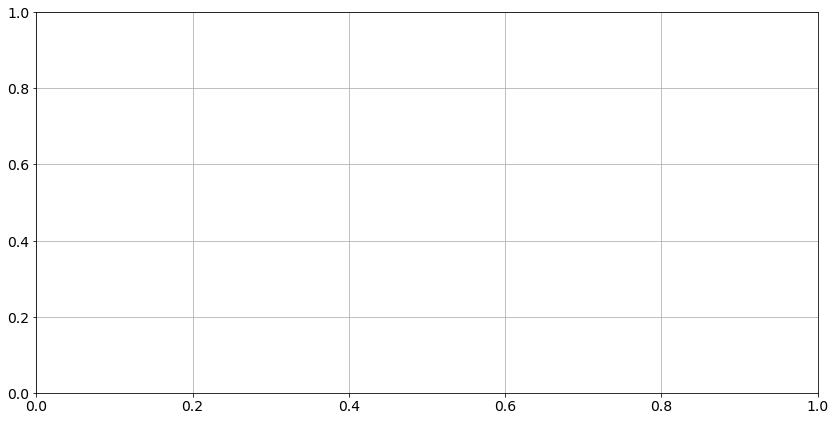

In [59]:
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

dfs = dfs.sort_values("data")
y = list(dfs.iloc[:, 3])

# Real data
# Brazilian areas separated

#plt.scatter(list(dfs[dfs['regiao'] == 'Norte'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Norte'].iloc[:, 3]), 
#            label = "Norte", color = "#c2cdd8")
#plt.scatter(list(dfs[dfs['regiao'] == 'Nordeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Nordeste'].iloc[:, 3]), 
#            label = "Nordeste", color = "#a1a9b4")
#plt.scatter(list(dfs[dfs['regiao'] == 'Sudeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Sudeste'].iloc[:, 3]), 
#            label = "Sudeste", color = "#3881b8")
#plt.scatter(list(dfs[dfs['regiao'] == 'Sul'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Sul'].iloc[:, 3]), 
#            label = 'Sul', color = '#235174')
#plt.scatter(list(dfs[dfs['regiao'] == 'Centro-Oeste'].iloc[:, 1]), list(dfs[dfs['regiao'] == 'Centro-Oeste'].iloc[:, 3]), 
#            label = 'Centro-Oeste', color = "#1d2b49")
plt.grid(True)

# regioes = dfs["regiao"].unique()
# estados = dfs["estado"] + "-" + dfs["regiao"]
# estados = list(estados.unique())
 
# for r in regioes : 
#     for e in estados :
#             plt.scatter(list(dfs[dfs['estado']].iloc[:, 1]), 
#                         list(dfs[dfs['estado'] == e].iloc[:, 3]), 
#                         label = e)
#     plt.title("Scatter of data in " + r)
#     plt.legend()
#     plt.xlabel("Days since 30 January 2020")
#     plt.ylabel("Number of infected people per day")
#     plt.xlim(30, max(x) + 2)
#     plt.ylim(0, max(y) * 1.1)
#     plt.show()

# estados

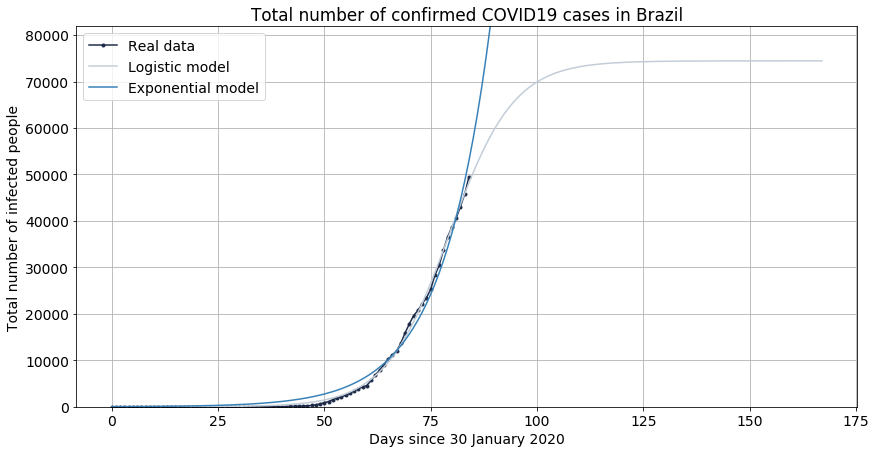

In [60]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), logistic_sol))
y = list(df1.iloc[:, 0])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2]) 
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of confirmed COVID19 cases in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()

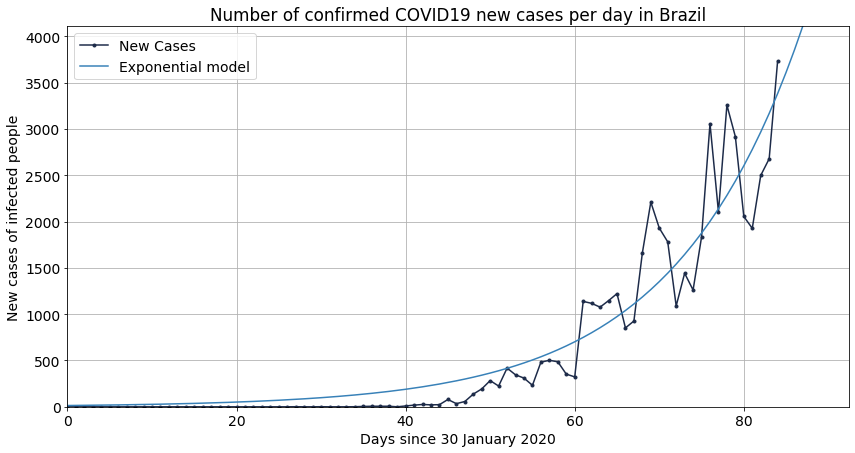

In [61]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), new_logistic_sol))
y = list(df1.iloc[:, 1])

plt.plot(x, y, marker = '.', label = "New Cases", color="#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_exponential_fit[0][0], new_exponential_fit[0][1], new_exponential_fit[0][2])
                    for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of confirmed COVID19 new cases per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New cases of infected people")
plt.ylim(0, max(y) * 1.1)
plt.xlim(0, max(x) * 1.1)
plt.show()

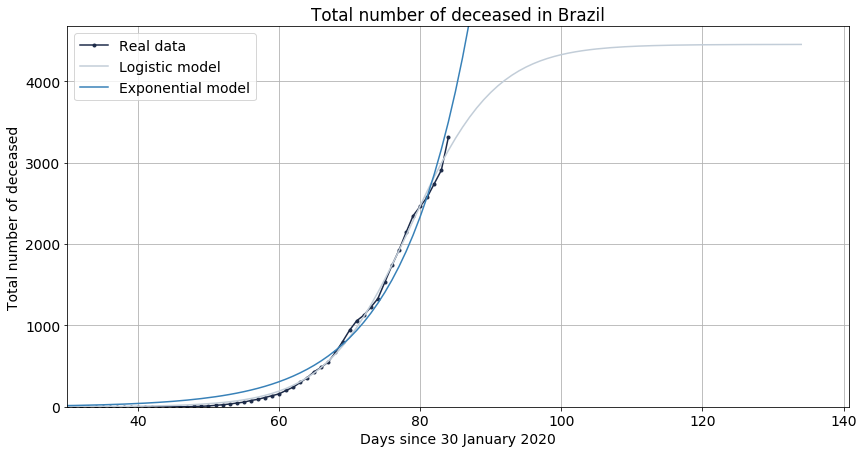

In [62]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 2])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, death_logistic_fit[0][0], death_logistic_fit[0][1], death_logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, death_exponential_fit[0][0], death_exponential_fit[0][1], death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total number of deceased in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Total number of deceased")
plt.xlim(30, max(pred_x) * 1.05)
plt.ylim(0, death_logistic_fit[0][2] * 1.05)
plt.show()

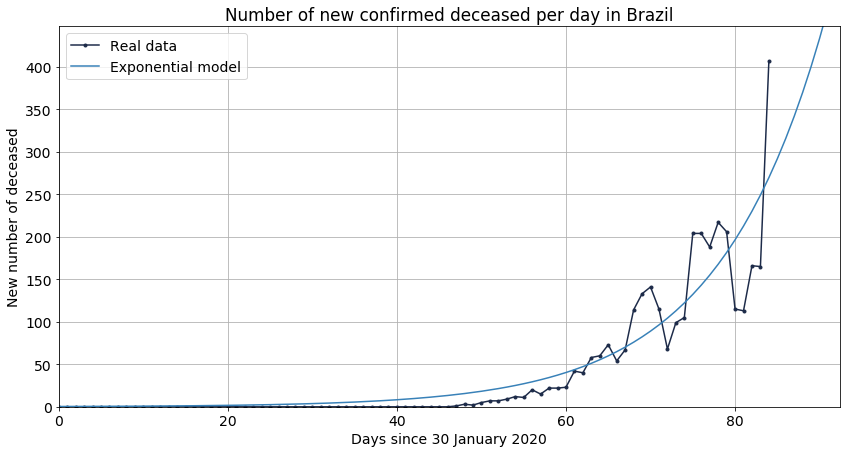

In [63]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

pred_x = list(range(max(x), death_logistic_sol))
y = list(df1.iloc[:, 3])

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, new_death_exponential_fit[0][0], new_death_exponential_fit[0][1], new_death_exponential_fit[0][2])
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Number of new confirmed deceased per day in Brazil")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("New number of deceased")
plt.xlim(0, max(x) * 1.1)
plt.ylim(0, max(y) * 1.1)
plt.show()

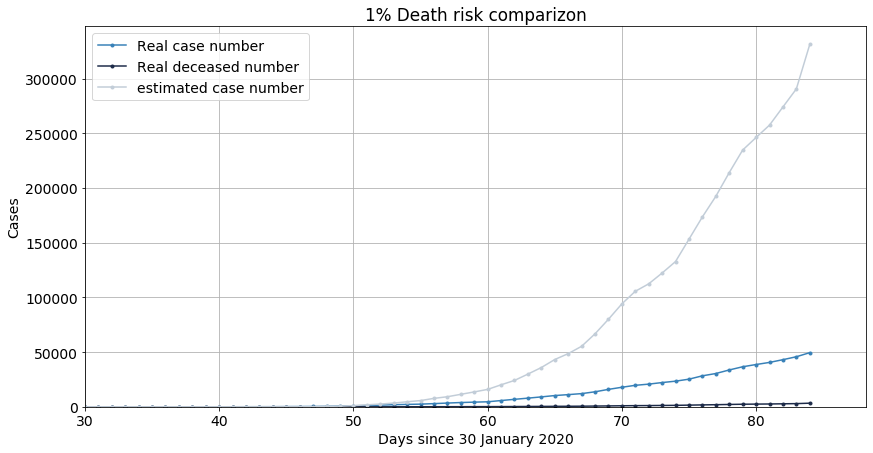

In [64]:
plt.grid(True)
plt.rc('font', size=14)
plt.rcParams['figure.figsize'] = [14, 7]

# Real data

y = list(df1.iloc[:, 0])
plt.plot(x, y, marker = '.', label = "Real case number", color = "#3881b8")

y = list(df1.iloc[:, 2])

plt.plot(x, y, marker = '.', label = "Real deceased number", color = "#1d2b49")

y = list(df1.iloc[:, 2].multiply(100))

plt.plot(x, y, marker = '.', label = "estimated case number", color = "#c2cdd8")

plt.title("1% Death risk comparizon")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.xlim(30, max(x) * 1.05)
plt.ylim(0, max(y) * 1.05)
plt.show()

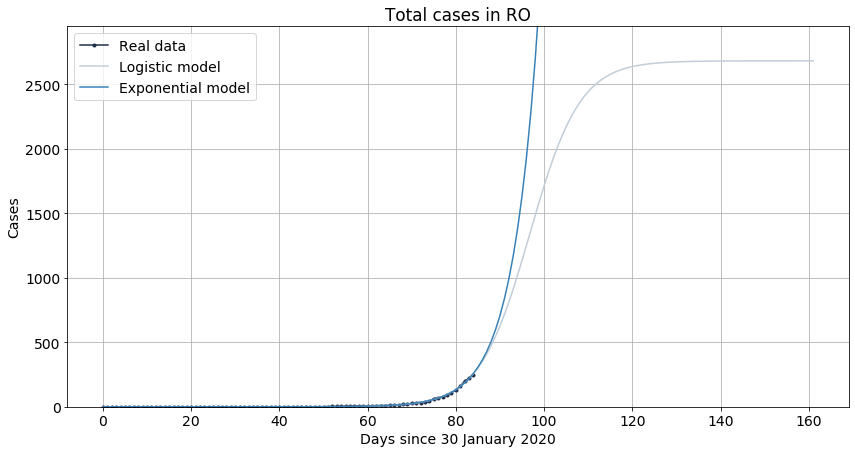

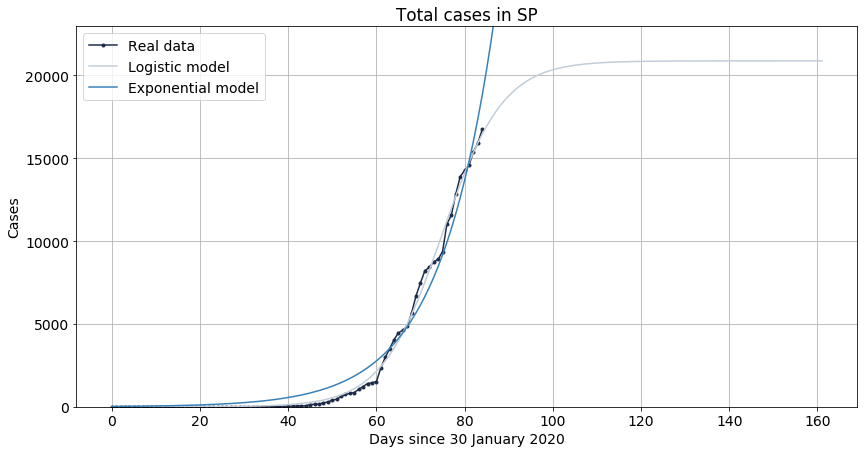

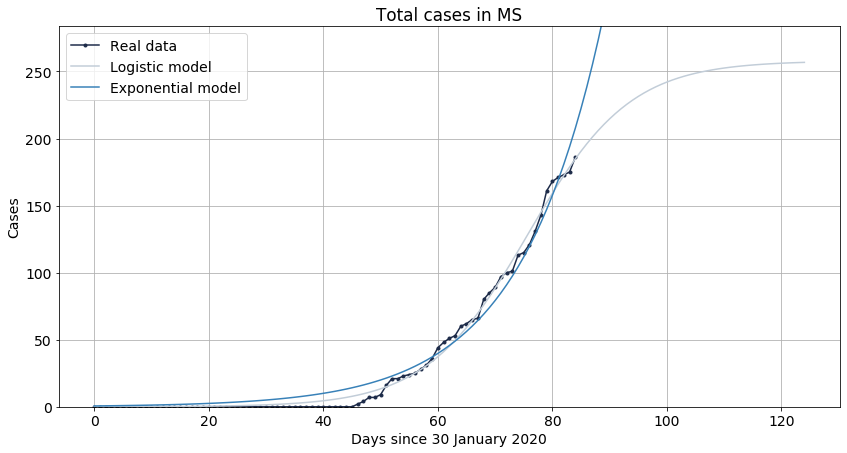

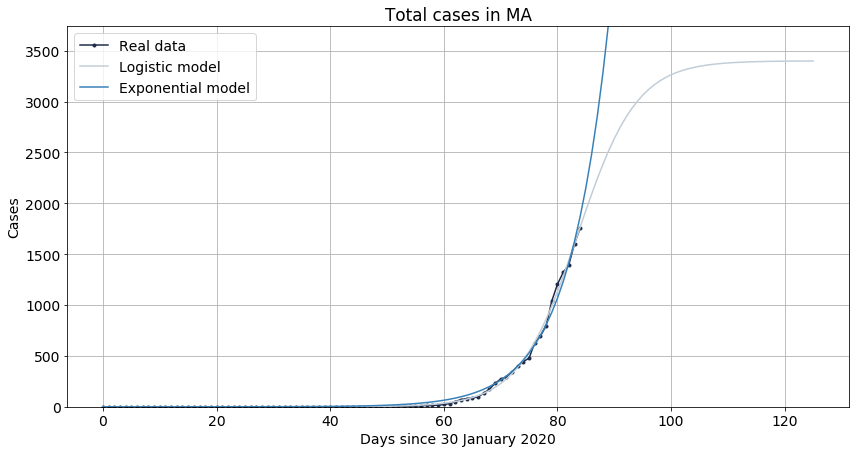

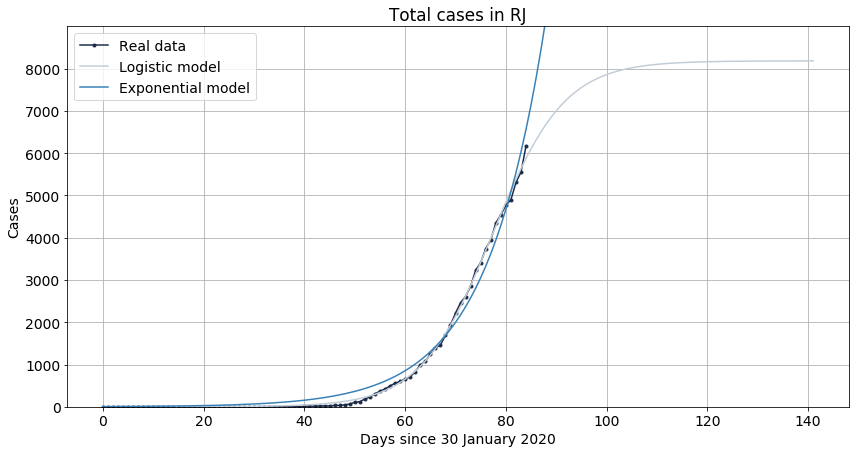

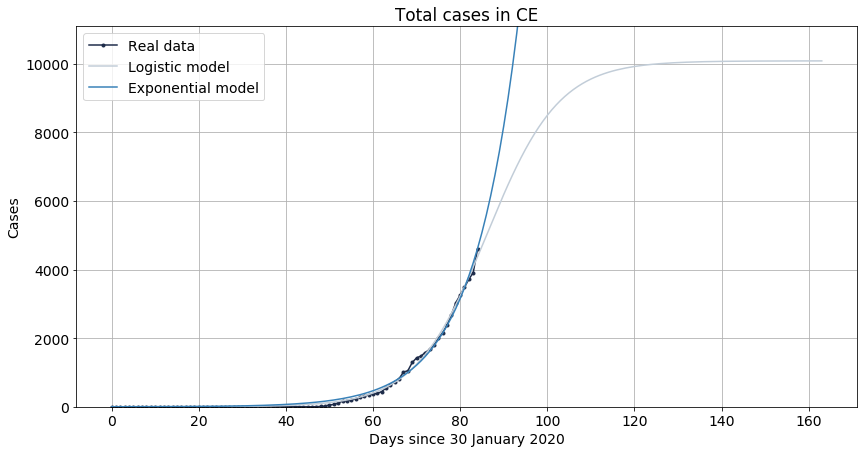

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

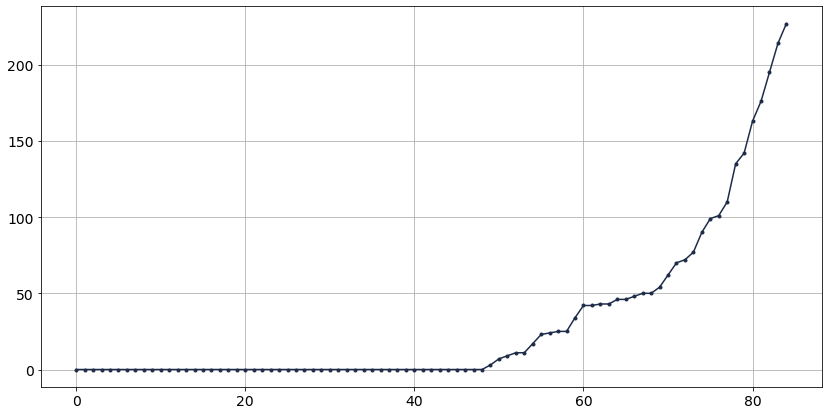

In [65]:
estados = dfs["estado"].unique()

for e in estados :
    df_e = df_UF.loc[df_UF.iloc[:,0] == e, :].iloc[:, [1, 2]]
    x = list(df_e.iloc[:, 0])
    y = list(df_e.iloc[:, 1])

    plt.grid(True)

    # Real data
    plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

    exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df_e.index.size))
    exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                              exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

    logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 20000])
    logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                        logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

    pred_x = list(range(max(x), logistic_sol))

    # Predicted logistic curve
    plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                          for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

    # Predicted exponential curve
    plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                          for i in x + pred_x], label = "Exponential model", color = "#3881b8")

    plt.title("Total cases in " + e)
    plt.legend()
    plt.xlabel("Days since 30 January 2020")
    plt.ylabel("Cases")
    plt.ylim(0, logistic_fit[0][2] * 1.1)
    plt.show()

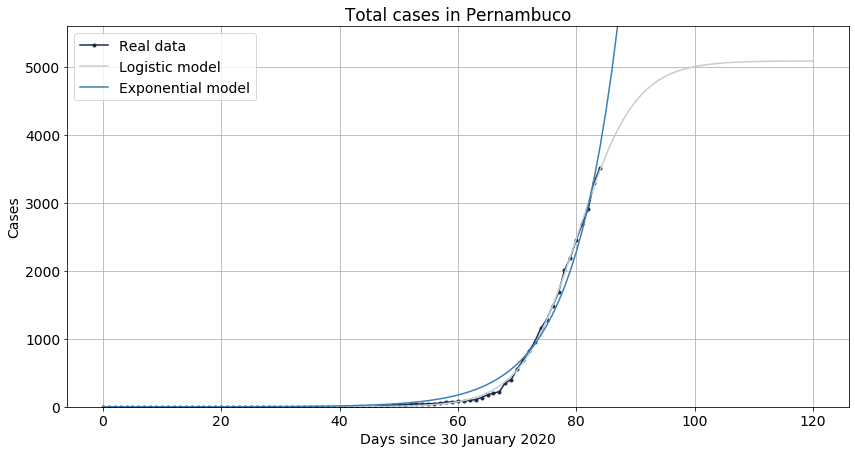

In [24]:
df_PE = df_UF.loc[df_UF.iloc[:,0] == 'PE', :].iloc[:, [1, 2]]

y = list(df_PE.iloc[:, 1])

plt.grid(True)

# Real data
plt.plot(x, y, marker = '.', label = "Real data", color = "#1d2b49")

exponential_fit = curve_fit(exponential_model, x, y, p0 = [1, 1, 1], bounds = (0, df.index.size))
exponential_sol = int(fsolve(lambda x : exponential_model(x, exponential_fit[0][0], exponential_fit[0][1], 
                                                          exponential_fit[0][2]) - int(exponential_fit[0][2]), exponential_fit[0][1]))

logistic_fit = curve_fit(logistic_model, x, y, p0 = [a0, b0, 0.4 * 9300000])
logistic_sol = int(fsolve(lambda x : logistic_model(x, logistic_fit[0][0], logistic_fit[0][1], 
                                                    logistic_fit[0][2]) - int(logistic_fit[0][2]), logistic_fit[0][1]))

pred_x = list(range(max(x), logistic_sol))

# Predicted logistic curve
plt.plot(x + pred_x, [logistic_model(i, logistic_fit[0][0], logistic_fit[0][1], logistic_fit[0][2])
                      for i in x + pred_x], label = "Logistic model", color = "#c2cdd8")

# Predicted exponential curve
plt.plot(x + pred_x, [exponential_model(i, exponential_fit[0][0], exponential_fit[0][1], exponential_fit[0][2]) 
                      for i in x + pred_x], label = "Exponential model", color = "#3881b8")

plt.title("Total cases in Pernambuco")
plt.legend()
plt.xlabel("Days since 30 January 2020")
plt.ylabel("Cases")
plt.ylim(0, logistic_fit[0][2] * 1.1)
plt.show()